In [ ]:
# !cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [2]:
%reload_ext autoreload
%autoreload 2
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [3]:
from collections import Counter, OrderedDict
from functools import partial

import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GroupKFold
from tqdm.auto import tqdm

import bundle
import features as F
import selection
import utils as U
from dataset import load, load_sample, Subset
from encode import encode
from training import train, inference, submit, EnsembleTrainer, get_default_config
from meta import compute_meta_data
from metric import optimize_rounding_bounds, make_cappa_metric
from normalize import normalize

In [4]:
sample = False
if U.on_kaggle():
    U.log('Loading test set only.')
    tst_data = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
else:
    if sample:
        U.log('Warning: loading train and test data sample.')
        trn_data, _, _ = load_sample(Subset.Train, 500_000)
        [tst_data] = load_sample(Subset.Test, 500_000)
    else:
        U.log('Loading train and test.')
        trn_data, trn_spec, trn_targ = load(Subset.Train)
        [tst_data] = load(Subset.Test)

Loading train and test.
(11341042, 11) (17690, 7) (386, 3) (1156414, 11) 

In [4]:
transform = U.combine(
    partial(F.add_feature_combinations, pairs=[('title', 'event_code')]),
    partial(F.add_datetime, column='timestamp', prefix='ts'),
)

if U.on_kaggle():
    U.log('Transforming test data only.')
    X_tst = transform(tst_data.copy())
    U.log(X_tst.shape)
else:
    U.log('Transforming train and test data.')
    X_tst = transform(tst_data.copy())
    X_trn = transform(trn_data.copy())
    U.log(X_trn.shape, X_tst.shape)

Transforming train and test data.
(11341042, 19) (1156414, 19)


In [5]:
if U.on_kaggle():
    U.log('Reading pre-computed meta from disk.')
    meta = bundle.meta()
else:
    U.log('Computing meta using train and test datasets.')
    meta = compute_meta_data(X_trn, X_tst)
    U.log('Saving computed meta on disk.')
    bundle.save_meta(meta, 'meta')

Computing meta using train and test datasets.
Saving computed meta on disk.


In [6]:
extractor = F.FeaturesExtractor([
    F.CountingFeatures(meta),
    F.PerformanceFeatures(meta),
    F.VarietyFeatures(meta),
    F.EventDataFeatures(meta),
    F.FeedbackFeatures(meta)
])

algo = F.InMemoryAlgorithm(extractor, meta, num_workers=12)

cat_cols = ['session_title']

if U.on_kaggle():
    U.log('Preparing test dataset.')
    X_tst = algo.run(X_tst, test=True)
    encoders = bundle.encoders()
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
else:
    U.log('Preparing train and test datasets.')
    X_trn = algo.run(X_trn)
    X_tst = algo.run(X_tst, test=True)
    X_trn, encoders = encode(X_trn, cat_cols)
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
    bundle.save(encoders, 'encoders')

Preparing train and test datasets.
Running algorithm in train mode.



Running algorithm in test mode.


In [7]:
if U.on_kaggle():
    U.log('Running post-processing on test set only.')
    F.add_user_wise_features(X_tst, meta)
else:
    U.log('Running post-processing on train and test sets.')
    F.add_user_wise_features(X_trn, meta)
    F.add_user_wise_features(X_tst, meta)

Running post-processing on train and test sets.


In [8]:
X_trn.to_pickle('/tmp/X_trn.pickle')

In [9]:
X_tst.to_pickle('/tmp/X_tst.pickle')

In [ ]:
X_trn = pd.read_pickle('/tmp/X_trn.pickle')
X_tst = pd.read_pickle('/tmp/X_tst.pickle')

In [ ]:
group_col = 'installation_id'
U.log(f'Normalizing dataset using column for grouping: {group_col}')
norm_dataset = X_tst if U.on_kaggle() else X_trn
cnt_cols = U.starts_with(norm_dataset.columns, 'cnt_')
normalize(norm_dataset, cnt_cols, grouping_key=group_col, method='min-max')

## Experiments

In [ ]:
X_trn = pd.read_pickle('/tmp/X_trn.pickle')
X_tst = pd.read_pickle('/tmp/X_tst.pickle')
cappa = make_cappa_metric(X_trn['accuracy_group'])
features = [c for c in X_trn.columns 
            if c not in ('installation_id', 'game_session', 'accuracy_group')]

In [ ]:
X_trn

In [ ]:
model_type = 'lightgbm'
trainer = EnsembleTrainer(algo=model_type, cv_metrics={'cappa': cappa})
fold = GroupKFold(n_splits=5)
config = get_default_config(model_type)
result = trainer.train(X_trn, features=features, fold=fold, config=config)

In [ ]:
cappa(X_trn['accuracy_group'].values, result.oof)

In [ ]:
# features from event_data
# https://www.kaggle.com/c/data-science-bowl-2019/discussion/124028

# truncated validation
# https://www.kaggle.com/ragnar123/truncated-val
# https://www.kaggle.com/c/data-science-bowl-2019/discussion/120790

# params = {'boosting_type': 'gbdt', 
#           'metric': 'rmse', 
#           'objective': 'regression', 
#           'eval_metric': 'cappa', 
#           'n_jobs': -1, 
#           'seed': 42, 
#           'num_leaves': 26, 
#           'learning_rate': 0.077439684887749, 
#           'max_depth': 33, 
#           'lambda_l1': 3.27791989030057, 
#           'lambda_l2': 1.3047627805931334, 
#           'bagging_fraction': 0.896924978584253, 
#           'bagging_freq': 1, 
#           'colsample_bytree': 0.8710772167017853}

In [ ]:
columns = X_trn.columns.tolist()
cnt_cols = U.starts_with(columns, 'cnt_')
perf_cols = U.starts_with(columns, 'perf_')
var_cols = U.starts_with(columns, 'var_')
user_cols = U.starts_with(columns, 'user_')
event_cols = U.starts_with(columns, 'event_')
cat_cols = ['session_title']
cols = cnt_cols + perf_cols + var_cols + user_cols + event_cols + cat_cols

features_groups = [
    ('cnt+perf+var', cnt_cols + perf_cols + var_cols),
    ('cnt+perf+user', cnt_cols + perf_cols + user_cols),
    ('cnt+perf+cat', cnt_cols + perf_cols + cat_cols),
    ('cnt+perf+var+user+cat', cnt_cols + perf_cols + var_cols + user_cols + cat_cols),
    ('event+cnt+perf', event_cols + cnt_cols + perf_cols),
    ('event+cnt+perf+user', event_cols + cnt_cols + perf_cols + user_cols),
    ('event+cnt+perf+var', event_cols + cnt_cols + perf_cols + var_cols),
    ('event+cnt+pert+cat', event_cols + cnt_cols + perf_cols + cat_cols),
    ('event+cnt+perf+user+var+cat', 
     event_cols + cnt_cols + perf_cols + user_cols + var_cols + cat_cols),
    ('all', cols),
    ('all-event', [c for c in cols if c not in event_cols])
]

In [ ]:
from sklearn.model_selection import GroupKFold
from training import EnsembleTrainer, get_default_config

model_type = 'lightgbm'
trainer = EnsembleTrainer(algo=model_type, cv_metrics={'cappa': cappa})
fold = GroupKFold(n_splits=5)
config = get_default_config(model_type)
U.set_nested(config, 'model_params.feature_fraction', 0.8)
U.set_nested(config, 'model_params.bagging_fraction', 0.75)
U.set_nested(config, 'model_params.bagging_freq', 1)

results = []
for col_group, features in features_groups:
    U.log(f'Training columns group: {col_group}')
    result = trainer.train(X_trn, features=features, fold=fold, config=config)
    results.append((col_group, result))

In [ ]:
report = pd.DataFrame([
    OrderedDict([('features', name)] + list(result.cv.items())) 
    for name, result in results])
cappa_cols = U.starts_with(report.columns, 'cv_cappa')
report['mean'] = report[cappa_cols].mean(axis=1)
report['std'] = report[cappa_cols].std(axis=1)
report.sort_values(by=['mean'], inplace=True, ascending=False)
report.reset_index(drop=True, inplace=True)
report.to_csv(f'report_{U.now()}.csv', index=False)

In [ ]:
def highlight_best(col):
    if not col.name.startswith('cv_cappa_'):
        return [''] * len(col)
    is_best = col.index == col.argmax()
    return ['background-color: salmon' if idx else '' for idx in is_best]

In [ ]:
report.style.apply(highlight_best)

## Event Data

In [5]:
import json
sample = trn_data.sample(1_000_000)
event_data = pd.io.json.json_normalize(sample.event_data.apply(json.loads))

In [6]:
from dataset import existing_info
stat_info = existing_info(event_data).T.reset_index()

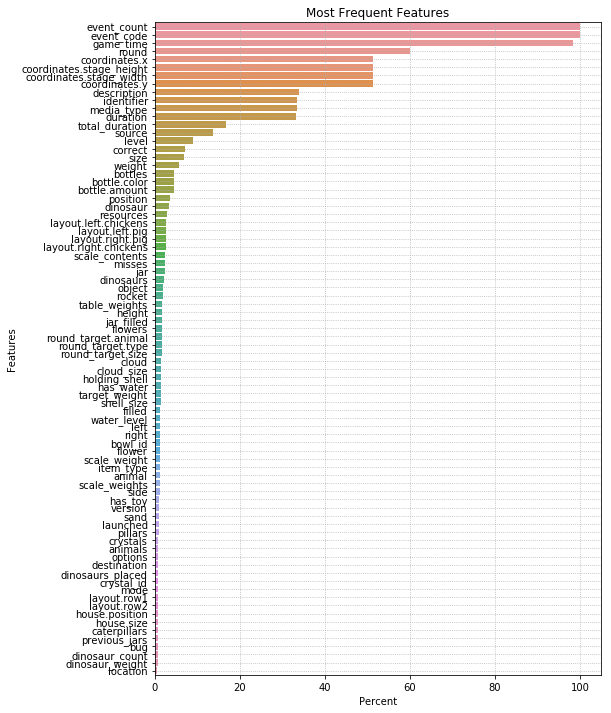

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 12))
ax = sns.barplot(x='Percent', y='index', data=stat_info.head(80))
ax.set_title('Most Frequent Features')
ax.set_ylabel('Features')
ax.grid(True, linestyle='dotted')

In [ ]:
U.show_all(event_data['identifier'].fillna('n/a').value_counts().reset_index())

In [ ]:
cnt = event_data['identifier'].fillna('n/a').value_counts().reset_index()

In [ ]:
import re
import os

In [ ]:
def transform_identifier(x):
    if U.starts_with_any(x, ['Dot', 'Buddy', 'Mom', 'Cleo']):
        parts = x.split(',')
        if len(parts) > 1:
            prefix = os.path.commonprefix(parts)
            n = len(prefix)
            trimmed = [U.camel_to_snake(part[n:]) for part in parts]
            string = '_'.join(trimmed)
        else:
            prefix = ''
            string = U.camel_to_snake(x.replace('_', ''))
        result = f'{prefix}{string}'
        return result.lower()
    return x

In [ ]:
POSITIVE_FEEDBACK = set([
    'dot_so_cool',
    'dot_great_job',
    'ohWow',
    'wowSoCool',
    'thatLooksSoCool',
    'niceJob',
    'tub_success',
    'water_success',
    'soap_success',
    'dot_whoa_so_cool',
    'dot_wow',
    'dot_amazing',
    'cleo_awe_of_your_skills',
    'greatJob_1306',
    'dot__you_did_it_sfx_completedtask',
    'RIGHTANSWER3',
    'RIGHTANSWER2',
    'RIGHTANSWER1',
    'AWESOME',
    'dot_awesome',
    'cleo_amazing_powers',
    'dot_nice_work_all_match',
    'GreatFlying',
    'youDidIt_1305'
])

NEGATIVE_FEEDBACK = set([
    'IncorrectTooHeavy_touch',
    'IncorrectTooLight',
    'dot_uhoh_need_try_again',
    'dot_so_low',
    'buddy_dinosaurs_awfully_thirsty_fill_clouds',
    'cleo_bowl_too_light',
    'dot_whoops_too_short',
    'REMOVE_WEIGHT',
    'NOT_THAT_HEAVY',
    'dot_uh_oh_too_tall',
    'wrong2',
    'wrong1',
    'tryAgain0_1333',
    'ADD_MORE_WEIGHT',
    'cleo_bowl_too_light_remember_heavier_bowl',
    'dot_whoops_not_balanced',
    'WrongOver',
    'wrongMore',
    'WrongBetweenTree',
    'wrongFewer',
    'WrongBetweenCliff',
])

In [ ]:
def transform_feedback(x):
    return ('positive' if x in POSITIVE_FEEDBACK else
            'negative' if x in NEGATIVE_FEEDBACK else
            'other')

In [ ]:
characters = 'dot', 'buddy', 'mom', 'cleo'
normalized = cnt['index'].map(transform_identifier)
character_identifiers = normalized.map(lambda x: U.starts_with_any(x, characters))
edi = pd.DataFrame({'identifier': normalized[character_identifiers]})
edi['character'] = event_data_ident['identifier'].map(lambda x: x.split('_')[0])
edi['feedback'] = event_data_ident['identifier'].map(transform_feedback)
U.show_all(edi)

In [ ]:
U.show_all(normalized.reset_index())

In [ ]:
U.show_all(cnt['index'].map(transform_identifier))

In [ ]:
# 'Dot_SoCool' --> 'dot_so_cool'
# 'Dot_AllDoneTapThis' --> 'dot_all_done'
# 'Dot_FillItUp' --> 'dot_fill_it_up'
# 'Dot_GreatJob' --> 'dot_great_job'
# 'Dot_TryWall' --> 'dot_try_wall'


In [ ]:
freq_keys = stat_info['index'][stat_info['Percent'] >= 5.].tolist()

In [ ]:
freq_keys

In [ ]:
round_df = event_data['round'].fillna(0).value_counts().reset_index()
round_df['index'] = round_df['index'].astype(int)
round_df.sort_values(by='index', inplace=True)
round_df.plot(x='index', y='round')

In [ ]:
np.isnan(event_data['coordinates.x'].iloc[3])

In [ ]:
event_data['coordinates.x'].fillna(0)

In [ ]:
event_data['media_type'].fillna('unknown').value_counts()

In [ ]:
event_data['source'].fillna('N/A').value_counts()

In [ ]:
levels = event_data['level'].fillna(0)
pd.cut(levels, [-np.inf, 3, 5, 8, 13, 21, np.inf], labels=[0, 1, 2, 3, 4, 5]).value_counts()

In [ ]:
event_data['size'].fillna(0).value_counts()

In [ ]:
event_data['weight'].fillna(0).value_counts()

In [ ]:
# round: float with NaNs
# coordinates.(x|y): float with NaNs, but presumably integer
# coordinates.stage_(width|height): float with NaNs, but presumably categorical
#
# description: text messages, try to convert into categoricals?
#     (event_data['description'].fillna('n/a').value_counts()
#      .rename('count').reset_index().rename(columns={'index': 'text'}))
#
# identifier: some string, probably concatenated with commas; most simple is to compute len
# event_data['identifier'].fillna('n/a').str.split(',').apply(len)
#
# media_type: categorical string
# event_data['media_type'].fillna('n/a').value_counts()
#
# duration: should already exist in the features set
# total_duration: probably also present in the features
#
# source: also some kind of categorical string
# event_data['source'].fillna('n/a').value_counts()
#
# level: integer feature, can be used as a cumulative metric (?)
# event_data['level'].fillna('n/a').value_counts()
#
# correct: defines if attempt was done, is already used in feature processing
# 
# size: integer feature
# event_data['size'].fillna('n/a').value_counts()
#
# weight: one more integer feature
# event_data['weight'].fillna('n/a').value_counts()

## Features Selection

In [ ]:
# selector = selection.FeatureSelection(
#     rules=[
#         ('nonzero', selection.non_zero_rows_and_cols),
#     ],
#     ignore_cols=[
#         'accuracy_group', 
#         'installation_id', 
#         'game_session'
#     ]
# )
# if U.on_kaggle():
#     U.log('Loading relevant features list from disk.')
#     features = bundle.features()
# else:
#     U.log('Deriving relevant features from train dataset.')
#     features = selector.select(X_trn)
#     bundle.save(features, 'features')

In [ ]:
if U.on_kaggle():
    U.log('Loading relevant features list from disk.')
    features = bundle.features()
else:
#     columns = features
#     cnt_cols = U.starts_with(columns, 'cnt_')
#     perf_cols = U.starts_with(columns, 'perf_')
#     var_cols = U.starts_with(columns, 'var_')
#     user_cols = U.starts_with(columns, 'user_')
#     ts_cols = U.starts_with(columns, 'ts_')
#     event_cols = U.starts_with(columns, 'event_')
#     cat_cols = ['session_title']
#     features = cnt_cols + perf_cols + user_cols + var_cols + event_cols + cat_cols
    features = [x for x in X_trn.columns 
                if x not in ('installation_id', 'game_session', 'accuracy_group')]
    bundle.save(features, 'features')
U.log(f'Total number of features: {len(features)}')

## Submission

In [ ]:
algo = 'lightgbm'
version = '020'

if U.on_kaggle():
    U.log('Inference on Kaggle.')
    features = bundle.features()
    bounds = bundle.bounds()
    predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
    U.log('Saving predictions on disk.')
    filename = submit(predicted)
    submit_df = pd.read_csv(filename)
    U.log('First 20 submission rows:')
    display(submit_df.head(20))
    
else:
    U.log(f'Training model: {algo}')
    cappa = make_cappa_metric(X_trn['accuracy_group'])
    trainer = EnsembleTrainer(algo=algo, cv_metrics={'cappa': cappa})
    fold = GroupKFold(n_splits=5)
    config = get_default_config(algo)
    U.set_nested(config, 'model_params.feature_fraction', 0.8)
    U.set_nested(config, 'model_params.bagging_fraction', 0.75)
    U.set_nested(config, 'model_params.bagging_freq', 1)
    result = trainer.train(X_trn, features=features, fold=fold, config=config)
    U.log('Saving the trained models')
    bundle.save(result.models, f'models_{algo}_{version}')
    U.log('Saving the optimal rounding bounds')
    bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'].values)
    U.log(f'Optimal bounds: {bounds}')
    bundle.save(bounds, 'bounds')
    U.log(f'Final features number: {len(features)}')
    bundle.save(features, 'features')

In [ ]:
if not U.on_kaggle():
    import os
    features = bundle.features()
    bounds = bundle.bounds()
    filename = submit(inference(X_tst, features, bounds, model=algo, version=version))
    assert os.path.exists(filename)
    assert pd.read_csv(filename).shape[0] == 1000
    bundle.package(folder='/home/ck/data/bowl2019/external/')

In [ ]:
%matplotlib inline

In [ ]:
pd.read_csv('submission.csv')['accuracy_group'].value_counts().reset_index().sort_values(by='index').set_index('index').plot.bar()

In [ ]:
X_trn['accuracy_group'].value_counts().reset_index().sort_values(by='index').set_index('index').plot.bar()